In [53]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [54]:
import h2o
h2o.init()
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 hours 50 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 19 days
H2O cluster name:,H2O_from_python_mikec_3w3xh5
H2O cluster total nodes:,1
H2O cluster free memory:,1.417 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [55]:
X_train = h2o.import_file('C:/Users/mikec/Codes/Practice/X_ncr.csv')
y_train = h2o.import_file('C:/Users/mikec/Codes/Practice/y_ncr.csv')
X_test = h2o.import_file('C:/Users/mikec/Codes/Practice/X_test.csv')
y_test = h2o.import_file('C:/Users/mikec/Codes/Practice/y_test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [56]:
# preparing the train and test data sets
# now convert tweet vecs and labels to a pandas dataframe and back to h2o dataframe
train = X_train.cbind(y_train)
test = X_test.cbind(y_test)

In [ ]:
# more on data prep
x = train.columns         # x: A list/vector of predictor column names or indexes. 
                          # This argument only needs to be specified if the user wants to exclude columns from the 
                          # set of predictors. If all columns (other than the response) should be used in prediction, 
                          # then this does not need to be set.

y = "labels"              # This argument is the name (or index) of the response column
x.remove(y)

# need to set train and test
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [58]:
# now the AUTO-ML piece comes in
aml = H2OAutoML(max_runtime_secs=1800) #max_models=10 or 20?, max_runtime_secs=3600
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [59]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20190807_155718,0.392106,0.220938,0.24442,0.0597413
StackedEnsemble_BestOfFamily_AutoML_20190807_155718,0.395083,0.226237,0.245358,0.0602004
GBM_1_AutoML_20190807_155718,0.437823,0.219238,0.248114,0.0615604
GBM_2_AutoML_20190807_155718,0.513985,0.326883,0.297228,0.0883447
GLM_grid_1_AutoML_20190807_155718_model_1,0.569663,0.251944,0.262021,0.0686548
DRF_1_AutoML_20190807_155718,0.617989,0.25629,0.265494,0.0704872


In [60]:
lb_pd = lb.as_data_frame()

In [61]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190807_155718
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.03685561243156502
RMSE: 0.19197815613127714

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.059741268871549194
RMSE: 0.2444202709914814


In [62]:
preds = aml.predict(test)
print(preds)

stackedensemble prediction progress: |████████████████████████████████████| 100%



predict,p0,p1,p2
1,0.0208439,0.976306,0.00284966
1,0.0196369,0.977654,0.0027086
1,0.0387619,0.953233,0.00800529
1,0.118376,0.868175,0.0134492
1,0.025927,0.97102,0.00305294
1,0.0183794,0.978917,0.00270366
1,0.0210516,0.976226,0.00272218
1,0.0455796,0.949222,0.00519883
1,0.0206084,0.9766,0.0027919
1,0.0198435,0.977441,0.00271507


In [63]:
var = preds["predict"].cbind(test[y])
print(var)

predict,labels
1,1
1,1
1,2
1,1
1,1
1,1
1,1
1,1
1,1
1,1


              precision    recall  f1-score   support

           0       0.53      0.30      0.38       164
           1       0.82      0.98      0.89      1905
           2       0.94      0.26      0.40       410

    accuracy                           0.82      2479
   macro avg       0.76      0.51      0.56      2479
weighted avg       0.82      0.82      0.78      2479

[[  49  114    1]
 [  29 1870    6]
 [  15  290  105]]
0.8164582492940702
0.7794921518057163


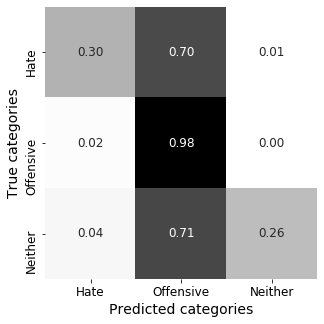

In [64]:
# convert to pandas dataframe
y_test = h2o.as_list(test[y], use_pandas=True)
y_pred = h2o.as_list(preds["predict"])
report = classification_report(y_test, y_pred)
print(report)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig('C:/Users/mikec/Documents/Results/Univariate3000NeighborhoodMax05.png')

f = open("C:/Users/mikec/Documents/Results/Univariate3000NeighborhoodMax05.txt", "a")
print("Univariate feature selection with 3000 features with Neighborhood Cleaning Rule, max run time 30 mins", file=f)
print(report, file=f)
print(metrics.confusion_matrix(y_test, y_pred), file=f)
print(metrics.accuracy_score(y_test, y_pred), file=f)
print(metrics.f1_score(y_test, y_pred, average='weighted'), file=f)
f.close()

In [65]:
file = lb_pd.to_csv('C:/Users/mikec/Documents/Results/Univariate3000neighborhoodMax05.csv')
#featuresSelected = uni_selected_feat.to_csv('C:/Users/mikec/Documents/Results/feature_selection.csv')